# クオンツ選考課題

## するべきこと
- 期待リスク、リターン、シャープレシオを計算する。
- リターンを一定に保つ。(今回は期待リスクとする)。目標値は4%。
- Tax Loss Harvesting戦略のモデルも作成する。
- 運用結果は図で示す。

## 前提や仕様
- 日経225から抽出した20銘柄と現金をポートフォリオの候補とする。
- Close(終値)を分析には使用する。
- ポートフォリオは225銘柄のweightで表現される。
- 各銘柄について、累計の期待リスク、リターン、シャープレシオを用意しておく。
- 10年の過去データでバックテストを行う。
- 3年分は基準指標の計算に利用し、7年分ポートフォリオ運用を回し、結果を分析する。
- ただしdropnaによって、どこかの企業が欠損しているデータがなくなってしまうため、10年すべてのデータを使用できているわけではない。
- 実際の運用を想定し、7年分のデータは1日ずつ流れ込んでくるとする(毎日このコードを回して更新する設定)。
- 無リスク金利はhttps://www.boj.or.jp/statistics/dl/loan/prime/prime.htmlに基づき、1.8%と仮に定める。
- 売買手数料は考慮しない。
- 借入レートと貸出レートはともに0とする。
- 空売りに関する制限はないものとする。

## 気になること
- Strategy部分とBacktest部分の分割がうまくいっているか。
- 実際の運用において、更新のタイミングやデータ処理スピードの要求値はどれくらいか
- リスクフリーレートは一定としたが、実際は可変なものである。他にも無視している指標は多くある。
- dropnaの影響力を十分に把握できていない。

## AIを使用した箇所
- yfinanceのセットアップと銘柄選定. 
日経225の銘柄のデータをyfinanceから取得するまでのプロセスにおいて、AIの助けを借りました。
- 最適化問題の実装において. 
最適なウェイトを見つける上でPythonで実装する方法がわからなかったため、助けを借りました。
特にfindValuesに関してはかなり頼ってしまっている。ただ、指示自体は理論的に指示を行った。末尾にその文を添付しています。
- Pythonの確認. 
Pythonのコード自体に自信がない際に、細かい部分に限って「これを実装するには？」や「この関数の文法を教えて」などの質問をしました。
- Tax Loss Harvesting. 
この戦略の理解が不安だったため、AIと認識のすり合わせを行いました。

具体的な使い方などはこのipynbの最後に添付します。

In [151]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [152]:
# 日経平均への寄与度や時価総額が高い主要20銘柄。AIに選定してもらいました。
major_20_tickers = [
    "9983.T", # ファーストリテイリング
    "8035.T", # 東京エレクトロン
    "6758.T", # ソニーグループ
    "7203.T", # トヨタ自動車
    "6857.T", # アドバンテスト
    "9984.T", # ソフトバンクグループ
    "4063.T", # 信越化学工業
    "6098.T", # リクルートホールディングス
    "8058.T", # 三菱商事
    "8306.T", # 三菱UFJフィナンシャル・グループ
    "6367.T", # ダイキン工業
    "4502.T", # 武田薬品工業
    "6501.T", # 日立製作所
    "6954.T", # ファナック
    "7741.T", # HOYA
    "4519.T", # 中外製薬
    "8001.T", # 伊藤忠商事
    "6981.T", # 村田製作所
    "2801.T", # キッコーマン
    "4901.T"  # 富士フイルムHLDG
]

In [153]:
# 該当銘柄データを取得
data = yf.download(major_20_tickers, period="10y")
closeData = data["Close"] #これが銘柄のデータ全体
returnData = data["Close"].pct_change().dropna() #これが%での変化
returnData["Cash"]=0

[*********************100%***********************]  20 of 20 completed


In [154]:
def findValues(rtrData: pd.DataFrame, target_daily: float, rf: float):
    """
    3年分のデータを踏まえて初期時点でのウェイトを計算する。各銘柄の期待リターンと共分散行列から、目標リターンを実現する最小分散のウェイトを計算しspilts outする。
    rtrData: n銘柄のリターンのデータ
    target_daily : 目標のリターン
    rf : リスクフリーレート
    """
    expectedReturn = rtrData.mean()
    expectedVariance = rtrData.cov()

    mu = expectedReturn.values
    Sigma = expectedVariance.values
    n_assets = len(mu)

    rf_daily = rf / 365

    # 目的関数: ポートフォリオ分散 w^T Σ w
    def portfolio_variance(w, Sigma):
        return w @ Sigma @ w

    # 制約1: 期待リターンが target_daily
    def constraint_return(w, mu, target):
        return w @ mu - target

    # 制約2: 重みの合計が 1 （フルインベスト）
    def constraint_weight_sum(w):
        return np.sum(w) - 1.0

    # 初期値: 等ウェイト
    w0 = np.ones(n_assets) / n_assets

    # 制約設定
    constraints = [
        {
            "type": "eq",
            "fun": constraint_return,
            "args": (mu, target_daily)
        },
        {
            "type": "eq",
            "fun": constraint_weight_sum
        }
    ]
    
    # 最適化実行
    result = minimize(
        fun=portfolio_variance,
        x0=w0,
        args=(Sigma,),
        method="SLSQP",
        constraints=constraints,
        bounds=tuple((0, 1) for _ in range(n_assets)) # 負の重みを防ぐための境界条件（任意）
    )

    if not result.success:
        raise RuntimeError("最適化に失敗しました: " + result.message)

    w_opt = result.x
    return_opt = w_opt @ mu
    variance_opt = w_opt @ Sigma @ w_opt
    sharpRatio_opt = (return_opt - rf_daily) / np.sqrt(variance_opt)
    
    return w_opt, return_opt, variance_opt, sharpRatio_opt

In [155]:
def findSubsequentValue(rtrData: pd.DataFrame, explorationData: pd.DataFrame, backtestDates: pd.Index, target_daily: float, rf: float):
    """
    初期のウェイトを踏まえて、その後そのポートフォリオの期待リターンをtarget_dailyにして推移を確認する。
    rtrData: リターンの10年分のデータ
    explorationData: 探索期間のデータ
    backtestDates: バックテスト用期間の日にちデータ
    target_daily: 初めのポートフォリオウェイト選定のための日次目標リターン
    rf : リスクフリーレート
    """
    all_dates = [explorationData.index[-1]] + list(backtestDates)
    
    weight_history = []
    return_history = pd.Series(index=all_dates, dtype=float)
    Var_history = pd.Series(index=all_dates, dtype=float)
    sharpRatio_history = pd.Series(index=all_dates, dtype=float)

    # 初期値の計算
    initialWeight, initialReturn, initialVar, initialSharpRatio = findValues(explorationData, target_daily, rf)
    
    weight_history.append(initialWeight)
    return_history.iloc[0] = initialReturn
    Var_history.iloc[0] = initialVar
    sharpRatio_history.iloc[0] = initialSharpRatio

    # 以降の推移を計算
    for i, d in enumerate(backtestDates):
        testdata = rtrData.loc[:d]
        # 前回の期待リターン(initialReturn)を目標リターンとして再最適化
        nextWeight, nextReturn, nextVar, nextSharpRatio = findValues(testdata, initialReturn, rf)
        
        weight_history.append(nextWeight)
        return_history.iloc[i+1] = nextReturn
        Var_history.iloc[i+1] = nextVar
        sharpRatio_history.iloc[i+1] = nextSharpRatio

    return weight_history, return_history, Var_history, sharpRatio_history

In [156]:
def runBackTest_Q1(rtrData: pd.DataFrame, target_daily: float, rf: float):
    """
    1問目についてバックテストを回す。
    ポートフォリオの期待リターン、期待リスク、シャープレシオの推移をグラフで表示する。
    rtrData: リターンの10年分のデータ
    target_daily: 初めのポートフォリオウェイト選定のための日次目標リターン
    rf : リスクフリーレート
    """

    beginingYear = rtrData.index[0].year
    explorationData = rtrData.loc[f"{beginingYear}":f"{beginingYear+2}"]
    backtestDates = rtrData.loc[f"{beginingYear+3}":].index

    weight_history, return_history, Var_history, sharpRatio_history = findSubsequentValue(
        rtrData, explorationData, backtestDates, target_daily, rf
    )
     
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    axes[0].plot(return_history.index, return_history.values, label="Expected Return", color="tab:orange")
    axes[0].set_ylabel("Exp. Return")
    axes[0].legend()
    axes[0].set_ylim(0, 0.001)

    axes[1].plot(Var_history.index, Var_history.values, label="Variance", color="tab:green")
    axes[1].set_ylabel("Variance")
    axes[1].legend()

    axes[2].plot(sharpRatio_history.index, sharpRatio_history.values, label="Sharpe Ratio", color="tab:blue")
    axes[2].set_ylabel("Sharpe Ratio")
    axes[2].set_xlabel("Date")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return weight_history, return_history, Var_history

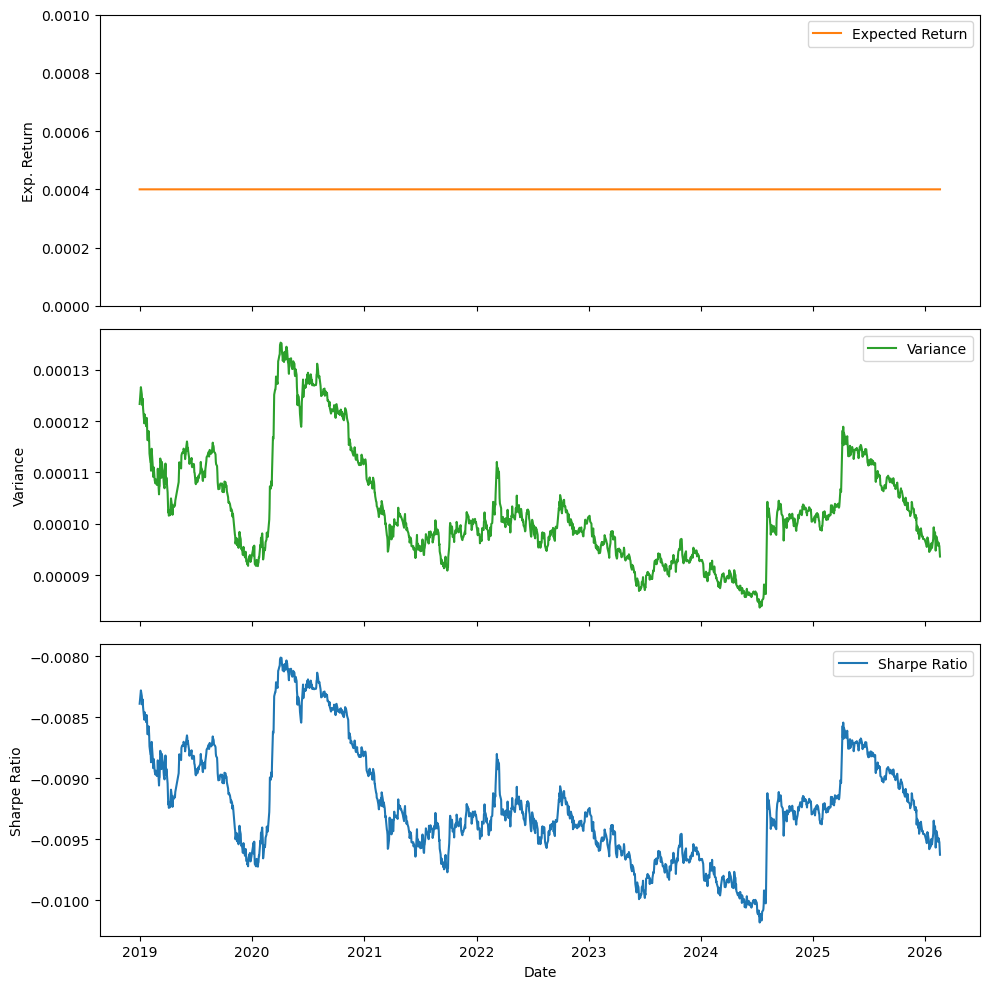

([array([0.03923331, 0.04245939, 0.11493096, 0.01823857, 0.08345829,
         0.        , 0.04236442, 0.06080613, 0.01224303, 0.        ,
         0.07735102, 0.06873688, 0.07496438, 0.03698721, 0.05055073,
         0.01320615, 0.03174224, 0.06780199, 0.02122398, 0.04782029,
         0.09588102]),
  array([0.03894891, 0.04341118, 0.10507821, 0.0202391 , 0.07781573,
         0.00312411, 0.04415693, 0.05946533, 0.01642479, 0.00380866,
         0.07571233, 0.07268824, 0.0706128 , 0.04275867, 0.0485201 ,
         0.0192791 , 0.03113765, 0.06347191, 0.02675463, 0.04817784,
         0.08841379]),
  array([0.0397543 , 0.0405801 , 0.11395422, 0.0133404 , 0.08524863,
         0.        , 0.04278972, 0.05962642, 0.00758699, 0.        ,
         0.08076314, 0.07659143, 0.07568861, 0.04056223, 0.04905041,
         0.00823077, 0.02692064, 0.06770367, 0.02323123, 0.04716361,
         0.10121349]),
  array([0.04259569, 0.04005918, 0.11726468, 0.01221169, 0.08909211,
         0.        , 0.04035172, 0

In [157]:
runBackTest_Q1(returnData,0.0004,0.18)

In [158]:
def findTaxLossHarvestingValue(rtrData: pd.DataFrame, explorationData: pd.DataFrame, backtestData: pd.DataFrame, target_daily: float, rf: float):
    """
    初期ウェイトをもとに、Tax Loss Harvesting戦略の推移を計算する。
    rtrData: リターンのデータ
    explorationData: 探索期間のデータ
    backtestData: バックテスト期間のデータ
    target_daily: 初期ウェイト計算用の目標リターン
    rf: リスクフリーレート
    """
    backtestDates = backtestData.index
    all_dates = [explorationData.index[-1]] + list(backtestDates)
    
    # 3年目終了時点を基準とした累積リターン
    cumReturn = (1 + backtestData).cumprod()

    weight_history = []
    return_history = pd.Series(index=all_dates, dtype=float)
    Var_history = pd.Series(index=all_dates, dtype=float)
    sharpRatio_history = pd.Series(index=all_dates, dtype=float)

    # 初期ウェイトの計算
    initialWeight, initialReturn, initialVar, initialSharpRatio = findValues(explorationData, target_daily, rf)
    
    weight_history.append(initialWeight.copy())
    return_history.iloc[0] = initialReturn
    Var_history.iloc[0] = initialVar
    sharpRatio_history.iloc[0] = initialSharpRatio

    rf_daily = rf / 365

    for i, d in enumerate(backtestDates):
        # その時点までの統計量を取得
        testdata = rtrData.loc[:d]
        mu = testdata.mean().values
        Sigma = testdata.cov().values

        # 含み損が発生している銘柄の特定
        current_cum_returns = cumReturn.loc[d]
        fallenComp = np.where(current_cum_returns < 1)[0]

        # ウェイトの調整
        currentWeight = weight_history[-1].copy()
        for idx in fallenComp:
            if currentWeight[idx] > 0:
                # 銘柄のウェイトをCashに移動
                currentWeight[-1] += currentWeight[idx]
                currentWeight[idx] = 0.0

        # 指標の算出
        port_return = currentWeight @ mu
        port_var = currentWeight @ Sigma @ currentWeight
        port_sharp = (port_return - rf_daily) / np.sqrt(port_var)

        weight_history.append(currentWeight.copy())
        return_history.iloc[i+1] = port_return
        Var_history.iloc[i+1] = port_var
        sharpRatio_history.iloc[i+1] = port_sharp

    return weight_history, return_history, Var_history, sharpRatio_history

In [159]:
def runBackTest_Q2(rtrData: pd.DataFrame, target_daily: float, rf: float):
    """
    2問目についてバックテストを回す。
    先に3年分のデータを用いて初期のウェイトを計算し、tax Loss Harvestingに移行する。
    3年目データ終了時の株価を保持しておき、各日付においての株価と初期時点株価を比較する。
    もし初期時点株価を下回っていたら、その銘柄のウェイトを0にし、現金にその銘柄のウェイト分を移動させる。
    時系列データとしてポートフォリオの期待リターン、期待リスク、シャープレシオをグラフで表示する。
    returnData: リターンの10年分のデータ
    target_daily: 初めのポートフォリオウェイト選定のための日次目標リターン
    rf : リスクフリーレート
    """

    beginingYear = rtrData.index[0].year
    explorationData = rtrData.loc[f"{beginingYear}":f"{beginingYear+2}"]
    backtestData = rtrData.loc[f"{beginingYear+3}":]

    # 数値計算部分の呼び出し
    weight_history, return_history, Var_history, sharpRatio_history = findTaxLossHarvestingValue(
        rtrData, explorationData, backtestData, target_daily, rf
    )
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    axes[0].plot(return_history.index, return_history.values, label="Expected Return", color="tab:orange")
    axes[0].set_ylabel("Exp. Return")
    axes[0].legend()
    axes[0].set_ylim(0, 0.0001)

    axes[1].plot(Var_history.index, Var_history.values, label="Variance", color="tab:green")
    axes[1].set_ylabel("Variance")
    axes[1].legend()

    axes[2].plot(sharpRatio_history.index, sharpRatio_history.values, label="Sharp Ratio", color="tab:blue")
    axes[2].set_ylabel("Sharp Ratio")
    axes[2].set_xlabel("Step")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return weight_history, return_history, Var_history

/var/folders/_5/80rp92qj06xby1j6gc1k5r100000gn/T/ipykernel_13173/2062257839.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  port_sharp = (port_return - rf_daily) / np.sqrt(port_var)


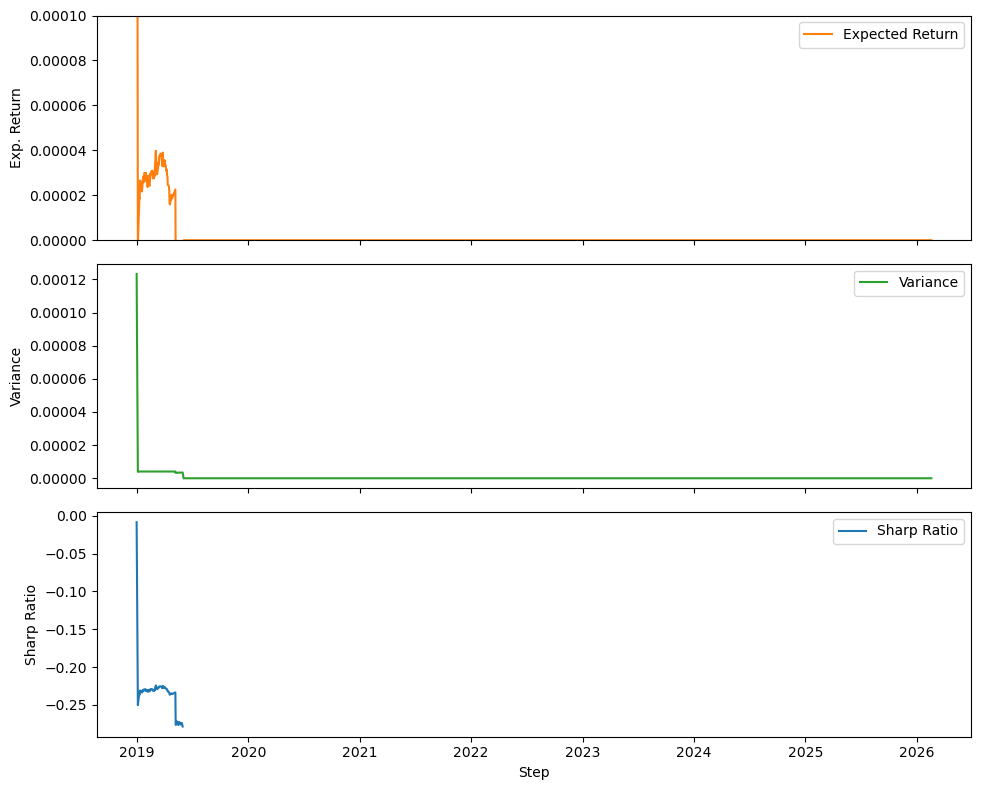

([array([0.03923331, 0.04245939, 0.11493096, 0.01823857, 0.08345829,
         0.        , 0.04236442, 0.06080613, 0.01224303, 0.        ,
         0.07735102, 0.06873688, 0.07496438, 0.03698721, 0.05055073,
         0.01320615, 0.03174224, 0.06780199, 0.02122398, 0.04782029,
         0.09588102]),
  array([0.        , 0.        , 0.11493096, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.03174224, 0.        , 0.        , 0.        ,
         0.85332679]),
  array([0.        , 0.        , 0.11493096, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.03174224, 0.        , 0.        , 0.        ,
         0.85332679]),
  array([0.        , 0.        , 0.11493096, 0.        , 0.        ,
         0.        , 0.        , 0

In [160]:
runBackTest_Q2(returnData,0.0004,0.18)

# AIへの指示
## yfinanceのセットアップと銘柄選定
「yfinanceを特定のipynbに対応させるには？」や「日経銘柄の取得をするには？」など、yfinance自体に関する質問を行い、助けてもらいました。
また、日経225に登録されている企業について、上場してから長い期間が経っていることと幅広い業界からピックアップするよう指示し、銘柄選定をしていただきました。

## 最適化部分の指示
この実装部分の知識が足りなかったため、指示を作成しました。

すでにある価格データからリターン(returnData)が作成できる
そこから期待リターンは
expectedReturn = returnData.aggregate(np.mean)
でそれぞれの銘柄について把握できて、全体の共分散行列は
expectedVariance = returnData.cov()
によって計算できる。ここまではPythonでOK

ここにおける最適なweightは、目標リターンを毎年
数学的に言えば、$\bar{R}_i$をその銘柄の期待リターンとして
$$\min_{w \in R^n} \{Var(\sum_{i=1}^{n} w_i \bar{R}_i)\}$$
$$s.t. \sum_{i=1}^{n} w_i \bar{R}_= 0.04$$
を生み出す$\{w_i\}_i$がその時点の最適ポートフォリオになる。 

この$w_i$のリストを吐き出す関数を作ってください

## Pythonの確認
単純にPythonの関数などがうろ覚えだったり、細かい部分で不明点があった際に質問しました。
「plotの文法は？」や「cumprodの値が1以下になったことのある銘柄を抽出するには？」など、の質問を通してコードの確認を行いました。

## Tax Loss Harvesting
について、「探索期間終了時の価格を下回ったらそれを売るっていうことだよね？ってことは現金っていう資産も追加しないとだよね？」のような形で理解の確認に使用しました。